<a href="https://colab.research.google.com/github/vaibhavsundharam/GANS/blob/main/Super_Resolution_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will implement super resolution using Generative Adversarial Networks(GAN). This work is inspired by the paper "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network" by Christian Ledig, Lucas Theis, Ferenc Husz´ar, Jose Caballero, Andrew Cunningham, Alejandro Acosta, Andrew Aitken, Alykhan Tejani, Johannes Totz, Zehan Wang, Wenzhe Shi [[1](https://arxiv.org/abs/1609.04802v5)].

#General Initializations

In [1]:
import torch
import sys
import os
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import cv2
import re
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import PIL
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
import glob
import random
import torch.optim as optim
from torch.autograd import Variable
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# modify "customized_path_to_project", path of folder in drive, where you have stored your project
customized_path_to_project = "/content/drive/My Drive/Computer Vision"
sys.path.append(customized_path_to_project)

#Data Preprocessing (data loaders and data augmentation) <br>
In the following section we will explore the DIV2K dataset [[2](https://data.vision.ee.ethz.ch/cvl/DIV2K/)]. The DIV2K dataset is divided into: <br>
*   Train data: starting from 800 high definition high resolution images we obtain corresponding low resolution images and provide both high and low resolution images for 2, 3, and 4 downscaling factors
*   Validation data: 100 high definition high resolution images are used for genereting low resolution corresponding images, the low res are provided from the beginning of the challenge and are meant for the participants to get online feedback from the validation server; the high resolution images will be released when the final phase of the challenge starts.
*   Test data: 100 diverse images are used to generate low resolution corresponding images; the participants will receive the low resolution images when the final evaluation phase starts and the results will be announced after the challenge is over and the winners are decided.

In [4]:
# Training data location
DIV2K_train_HR = os.path.join(customized_path_to_project, "Data/DIV2K/DIV2K_train_HR")
DIV2K_train_LR_bicubic = os.path.join(customized_path_to_project, "Data/DIV2K/DIV2K_train_LR_bicubic/X4")
DIV2K_train_LR_unknown = os.path.join(customized_path_to_project, "Data/DIV2K/DIV2K_train_LR_unknown/X4")

# Validation data location
DIV2K_valid_HR = os.path.join(customized_path_to_project, "Data/DIV2K/DIV2K_valid_HR")
DIV2K_valid_LR_bicubic = os.path.join(customized_path_to_project, "Data/DIV2K/DIV2K_valid_LR_bicubic/X4")
DIV2K_valid_LR_unknown = os.path.join(customized_path_to_project, "Data/DIV2K/DIV2K_valid_LR_unknown/X4")

# Testing data location
DIV2K_test_LR_bicubic = os.path.join(customized_path_to_project, "Data/DIV2K/DIV2K_test_LR_bicubic/X4")
DIV2K_test_LR_unknown = os.path.join(customized_path_to_project, "Data/DIV2K/DIV2K_test_LR_unknown/X4")

Storing image locations in a CSV file for further processing 

In [5]:
# Training Data
training_data = [DIV2K_train_HR, DIV2K_train_LR_bicubic, DIV2K_train_LR_unknown]
for folder in training_data:
  csv_file_name = str(folder.split("/")[-2])+ str(folder.split("/")[-1]) + ".csv"
  #print(csv_file_name)
  image_name_list = list()
  for image_loc in glob.glob(folder+"/*.png"):
    image_name = image_loc.split("/")[-1]
    #print(image_name)
    image_name_list.append(image_name)
    image_name_list.sort()
  with open(csv_file_name, "w") as out:
    for image in image_name_list:
      out.write(folder + "/" + image + "\n")    

In [6]:
# Validation Data
training_data = [DIV2K_valid_HR, DIV2K_valid_LR_bicubic, DIV2K_valid_LR_unknown]
for folder in training_data:
  csv_file_name = str(folder.split("/")[-2])+ str(folder.split("/")[-1]) + ".csv"
  #print(csv_file_name)
  image_name_list = list()
  for image_loc in glob.glob(folder+"/*.png"):
    image_name = image_loc.split("/")[-1]
    #print(image_name)
    image_name_list.append(image_name)
    image_name_list.sort()
  with open(csv_file_name, "w") as out:
    for image in image_name_list:
      out.write(folder + "/" + image + "\n")   

In [7]:
# Testing Data
training_data = [DIV2K_test_LR_bicubic, DIV2K_test_LR_unknown]
for folder in training_data:
  csv_file_name = str(folder.split("/")[-2])+ str(folder.split("/")[-1]) + ".csv"
  #print(csv_file_name)
  image_name_list = list()
  for image_loc in glob.glob(folder+"/*.png"):
    image_name = image_loc.split("/")[-1]
    #print(image_name)
    image_name_list.append(image_name)
    image_name_list.sort()
  with open(csv_file_name, "w") as out:
    for image in image_name_list:
      out.write(folder + "/" + image + "\n")    

#Datasets and Image Augmentations

In [8]:
# custom class to explore dataset
class DIV2K_dataset(Dataset):
  def __init__(self, HR_csv_location, LR_csv_location, transform=None):
    self.transform = transform
    self.HR_csv = pd.read_csv(HR_csv_location, header=None)
    self.LR_csv = pd.read_csv(LR_csv_location, header=None)       

  def __len__(self):  # returns the length of the data set
     return len(self.LR_csv)

  def __getitem__(self, idx):  

    images = dict()

    HR_image_location = str(self.HR_csv.iloc[idx, 0])
    LR_image_location = str(self.LR_csv.iloc[idx, 0])    
    images["HR"] = cv2.imread(HR_image_location)
    images["LR"] = cv2.imread(LR_image_location)
    #print("Debug:", HR_image_location)
        
    if self.transform == None:
      images["HR"] = images["HR"].transpose(2, 0, 1).astype(np.float32)
      images["LR"] = images["LR"].transpose(2, 0, 1).astype(np.float32)
      return images 

    else:
      images = self.transform(images)      
      return images       

In [9]:
class Random_Crop(object):
  '''
  In this class an input low resolutiona and high resolution image
  is cropped
  '''
  def __init__(self, scale, patch_size):
    self.scale = scale
    self.patch_size = patch_size

  def __call__(self, sample):
    HR, LR = sample["HR"], sample["LR"] 
    height, width = LR.shape[:2]

    x = random.randrange(0, width - self.patch_size +1)    
    y = random.randrange(0, height - self.patch_size +1)    
    
    LR_patch = LR[y : y + self.patch_size, x : x + self.patch_size]
    HR_patch = HR[self.scale * y : self.scale*(y + self.patch_size), self.scale*x : self.scale*(x + self.patch_size)]
    return {"HR": HR_patch, "LR": LR_patch}

In [10]:
class Data_Augmentation(object):
  '''
  This class implements random horizontal flipping,
  random virticle flipping and random rotation to an 
  imput image
  '''
  def __call__(self, sample):
    HR, LR = sample["HR"], sample["LR"]
    horizontal_flip = random.randrange(0,2)
    vertical_flip = random.randrange(0,2)
    rotation = random.randrange(0,2)

    if horizontal_flip == 1:      
      LR = np.fliplr(LR)      
      HR = np.fliplr(HR)       

    if vertical_flip ==1:       
      LR = np.flipud(LR)      
      HR = np.flipud(HR)       

    if rotation == 1:
      LR = LR.transpose(1, 0, 2)
      HR = HR.transpose(1, 0, 2)  

    return { "HR" : HR, "LR" : LR}

In [11]:
class Normalize(object):
  '''
  Normalizing and centering input images and converting it to tensor
  '''
  def __init__(self):
    self.transform = transforms.Compose([transforms.ToPILImage(),                            
                              transforms.ToTensor(),
                              transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                std = [0.229, 0.224, 0.225]) ])
  def __call__(self, sample, esp=1e-6):
    HR, LR = sample["HR"], sample["LR"]
    HR = self.transform(HR)
    LR = self.transform(LR)
    return { "HR" : HR, "LR" : LR}

# Data exploration<br>
Here we plot some samples from the training data to visualize the data

In [12]:
csvfile_hr = pd.read_csv("/content/DIV2KDIV2K_train_HR.csv")
csvfile_lr_bicubic = pd.read_csv("/content/DIV2K_train_LR_bicubicX4.csv")
csvfile_lr_unknown = pd.read_csv("/content/DIV2K_train_LR_unknownX4.csv")
random_samples = random.sample(range(len(csvfile_hr)), k=5) # generating 5 random samples 

HR_images = [csvfile_hr.iloc[i, 0] for i in random_samples]
LR_bicubic_images = [csvfile_lr_bicubic.iloc[i, 0] for i in random_samples]
LR_unknown_images =  [csvfile_lr_unknown.iloc[i, 0] for i in random_samples]

In [13]:
def plot(HR, LR_b, LR_u):
  fig, axs = plt.subplots(len(HR), 3, figsize =(20,20))

  for i in range(len(HR)):
    axs[i][0].imshow(plt.imread(HR[i]))
    axs[i][0].set_title("High resolution images")
    axs[i][1].imshow(plt.imread(LR_b[i]))
    axs[i][1].set_title("Low resolution-bicubic downgrading")
    axs[i][2].imshow(plt.imread(LR_u[i]))
    axs[i][2].set_title("Low resolution-unknown downgrading") 
    plt.show()

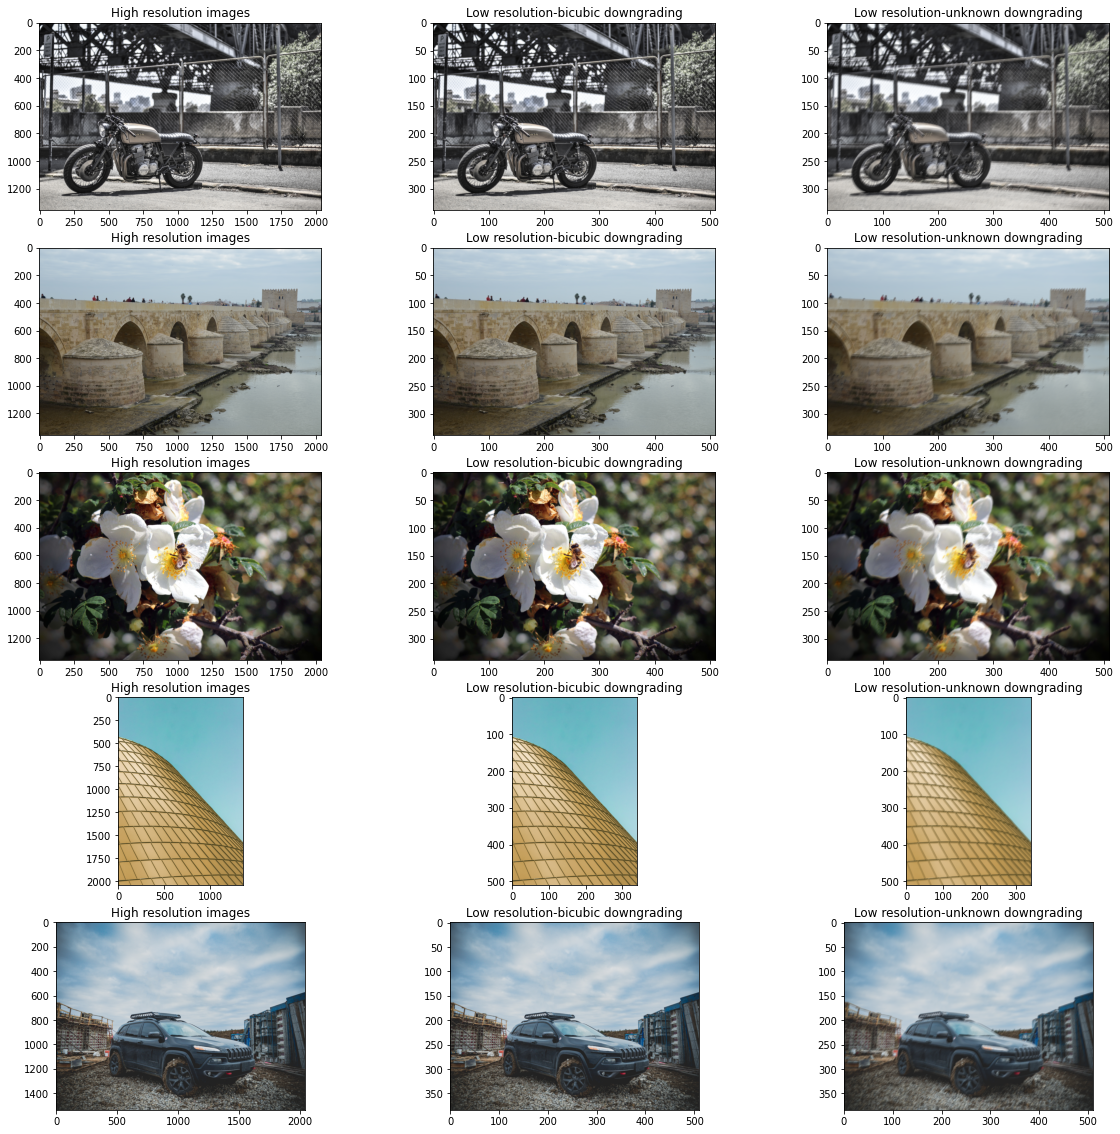

In [ ]:
plot(HR_images, LR_bicubic_images, LR_unknown_images )

# Designing GAN<br>
Following image depicts the architecture of the Generator and Discriminator used in [[1](https://arxiv.org/abs/1609.04802v5)].<br><br>
![picture](https://drive.google.com/uc?export=view&id=1VHFW7OHHplXP-iajx8zvcDP2gpg0JWh3)

In [14]:
class conv_block(nn.Module):
  '''
  A conv block is a sequantial model with convolution layer followed by batch
  normalization and activation
  '''
  def __init__(self, in_channels, out_channels, kernel_size, activation=None, BN=False, stride=1):
    super(conv_block, self).__init__()
    layers = list()
    layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, 
                           padding=(kernel_size//2)))
    
    if (BN == True):
      layers.append(nn.BatchNorm2d(num_features=out_channels))

    if activation is not None:
      layers.append(activation)

    self.Conv_Block = nn.Sequential(*layers)

  def forward(self, x):
    return self.Conv_Block(x)

In [15]:
class residual_block(nn.Module):
  '''
  each residual block consists of 2 convolution layers with a kernel size of 3,
  number of channels=64 and a stride of 1
  '''
  def __init__(self, channels, kernel_size, activation = nn.PReLU(), BN=False):
    super(residual_block, self).__init__()
    block = list()

    block.append(conv_block(channels, 
                            channels, 
                            kernel_size, 
                            BN=True, 
                            activation=activation))
    block.append(conv_block(channels, 
                            channels, 
                            kernel_size, 
                            BN=True, 
                            activation=None))
    self.Residual_Block = nn.Sequential(*block)

  def forward(self, x):
    res = self.Residual_Block(x)
    res = res + x
    return res

In [16]:
class GUpSamplerBlock(nn.Module):
  '''
  Upsampling block in SRGAN
  '''
  def __init__(self, channels, kernel_size, num_up_sample_blocks, scale, activation=nn.PReLU()):
    super(GUpSamplerBlock, self).__init__()
    layers = list()
    
    layers.append(conv_block(channels, channels*scale*scale, kernel_size))
    layers.append(nn.PixelShuffle(scale))

    if activation is not None:
      layers.append(activation)
    
    self.gupsamplerblock = nn.Sequential(*layers)
  
  def forward(self, x):
    x = self.gupsamplerblock(x)
    return x

In [17]:
class d_conv_block(nn.Module):
  '''
  convolution layers used in discrimiantor
  '''
  def __init__(self, in_channels, out_channels, kernel_size, activation=nn.LeakyReLU(), BN=False, stride=1):
    super(d_conv_block, self).__init__()
    layers = list()
    layers.append(conv_block(in_channels, 
                             out_channels, 
                             kernel_size, 
                             activation=activation, 
                             BN=True, stride=stride)) 
       
    layers.append(conv_block(out_channels, 
                             out_channels, 
                             kernel_size, 
                             activation=activation, 
                             BN=True, stride=2))
    
    self.D_Conv_Block = nn.Sequential(*layers)

  def forward(self, x):
    return self.D_Conv_Block(x)

In [18]:
class TV_Loss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TV_Loss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, sample):
        batch_size = sample.size()[0]
        height = sample.size()[2]
        width = sample.size()[3]
        count_h = self.tensor_size( sample[:, :, 1:, :])
        count_w = self.tensor_size( sample[:, :, :, 1:])
        h_tv = torch.sum(torch.pow(( sample[:, :, 1:, :] -  sample[:, :, :height - 1, :]), 2))
        w_tv = torch.sum(torch.pow(( sample[:, :, :, 1:] -  sample[:, :, :, :width - 1]), 2))
        
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(x):
        return x.size()[1] * x.size()[2] * x.size()[3]

In [19]:
class Generator(nn.Module):
  def __init__(self, image_features=3, n_features=64, kernel_size=3, num_res_blocks=5, num_up_sample_blocks=2, scale=4, activation=nn.PReLU()):
    super(Generator, self).__init__()
    self.conv_layer_1 = conv_block(in_channels=image_features, 
                                   out_channels=n_features, 
                                   kernel_size=9, BN= False, 
                                   activation=activation)
    
    residual_blocks = [residual_block(channels = n_features, 
                                      kernel_size = 3, 
                                      activation=activation) 
                                      for layer in range(num_res_blocks)]

    self.residual_blocks = nn.Sequential(*residual_blocks)

    self.conv_layer_2 = conv_block(in_channels=n_features, 
                                   out_channels=n_features, 
                                   kernel_size=3, BN=True, 
                                   activation=None)

    if (scale==4):
      upscaleblocks = [GUpSamplerBlock(channels=n_features, 
                                       kernel_size=kernel_size, 
                                       num_up_sample_blocks=num_up_sample_blocks, 
                                       scale=2,
                                       activation=activation)
                                       for layer in range(num_up_sample_blocks)]
                                      
    else:
      upscaleblocks = [GUpSamplerBlock(channels=n_features, 
                                       kernel_size=kernel_size, 
                                       num_up_sample_blocks=num_up_sample_blocks, 
                                       scale=scale,
                                       activation=activation)
                                       for layer in range(num_up_sample_blocks)]

    self.upscaleblocks = nn.Sequential(*upscaleblocks)
    self.conv_last = conv_block(in_channels=n_features , 
                                out_channels=image_features, 
                                kernel_size = 9,
                                BN = False, 
                                activation = nn.Tanh())
  def forward(self, x):
    x = self.conv_layer_1(x)
    skip_connection = x
    x = self.residual_blocks(x)
    x = self.conv_layer_2(x)
    features = x + skip_connection
    x = self.upscaleblocks(features)
    x = self.conv_last(x)
    return x   

In [20]:
class Discriminator(nn.Module):
  def __init__(self, image_features=3, n_features=64, kernel_size=3, num_blocks=3, activation=nn.LeakyReLU(), patch_size = 96):
    super(Discriminator, self).__init__()
    
    self.conv_layer_1 =  conv_block(in_channels=image_features, 
                                      out_channels=n_features,
                                      kernel_size=kernel_size,
                                      activation=activation,
                                      BN=False
                                      )
    
    self.conv_layer_2 = conv_block(in_channels=n_features, 
                                      out_channels=n_features,
                                      kernel_size=kernel_size,
                                      activation=activation,
                                      BN=True,
                                      stride=2)
    
    
    d_conv_blocks = [d_conv_block(in_channels=(n_features * (2 ** i)),
                                       out_channels=(n_features * (2 ** (i + 1))),
                                       kernel_size = 3,
                                       activation=activation,
                                       BN=True) for i in range(num_blocks)]
    
    self.d_conv_blocks = nn.Sequential(*d_conv_blocks)       
    self.linear_size = ((patch_size // (2 ** (num_blocks + 1))) ** 2) * (n_features * (2 ** num_blocks))
    fc_last = list()    
    fc_last.append(nn.Linear(self.linear_size, 1024))
    fc_last.append(activation)
    fc_last.append(nn.Linear(1024, 1))    
    fc_last.append(nn.Sigmoid())
    self.fc_last = nn.Sequential(*fc_last)
    self.flatten = nn.Flatten()

  def forward(self, x):
    x = self.conv_layer_1(x)
    x = self.conv_layer_2(x)
    x = self.flatten(self.d_conv_blocks(x))    
    output = self.fc_last(x)
    return output

# Model training 

In [21]:
def image_show(lr_images, fake_hr_images, real_hr_images):
  transform = transforms.Compose([transforms.Normalize(mean = [-2.118, -2.036, -1.804], # Equivalent to un-normalizing ImageNet (for correct visualization)
                                                                    std = [4.367, 4.464, 4.444]),
                                            transforms.ToPILImage()])
  figure,axs =  plt.subplots(1, 3, figsize =(10,10))
  i = random.randint(0, lr_images.shape[0] -1) # randomly selecting any image in the batch
  lr_image =transform(lr_images[i])
  fake_hr_image = transform(fake_hr_images[i])
  real_hr_image = transform(real_hr_images[i])

  axs[0].imshow(lr_image)
  axs[0].set_title("Low resolution crop of an image")
  axs[1].imshow(fake_hr_image)
  axs[1].set_title("High resolution fake image")
  axs[2].imshow(real_hr_image)
  axs[2].set_title("High resolution real/target image")
  plt.show()

In [22]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/generator/'
os.makedirs(output_dir, exist_ok=True)

In [23]:
def train(HR_csv_location, LR_csv_location, pre_train_epoch, SRGAN_train_epoch, batch_size, num_workers, lr=1e-4, scale=4, patch_size=96, vgg_rescale_coeff=1, adversarial_loss_coeff=1e-3):

 
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch.cuda.empty_cache()
  transform = transforms.Compose([Random_Crop(scale=scale, patch_size=patch_size),
                                  Data_Augmentation(),
                                  Normalize()])

  dataset = DIV2K_dataset(HR_csv_location, LR_csv_location, transform=transform)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  print(f"Total number of training example: {len(dataset)}\n")
  ### model initialization ###
  generator = Generator().to(device)  
  g_optimizer = optim.Adam(generator.parameters(), lr = lr)
  ############################

  ### optimizer initialization#
  discriminator = Discriminator(patch_size=patch_size*scale).to(device) 
  d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)     
  #############################

  ### other initializations ###
  total_step = len(loader)
  log_step = 50 
  scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size = 2000, gamma = 0.1)
  #############################

  ### initializing VGG model###      
  vgg19 = models.vgg19(pretrained=True)
  modified_vgg19 =  list(vgg19.children())[:-2]
  vgg19 = nn.Sequential(*modified_vgg19).to(device)
  vgg19.eval()
  #############################
  
  ### initializing lossess ###  
  bce_loss = nn.BCELoss()  
  mse_loss =nn.MSELoss()
  tv_loss = TV_Loss()
  ############################

  with torch.autograd.set_detect_anomaly(True):
    # Pre-train generator using raw MSE loss
    print("------Pretraing Generator------")
    mean_generator_pre_content_loss = 0.0
    for epoch in range(pre_train_epoch):      
      generator.train()
      for itr, data in enumerate(loader):        
        hr_image = Variable(data["HR"].float().to(device)) # high resolution real
        lr_image = Variable(data["LR"].float().to(device)) # low resolution

        ### pre train generator ###        
        generator.zero_grad()  

        generator_output = generator(lr_image) # high resolution fake
        generator_pre_loss = mse_loss(hr_image, generator_output)      
        mean_generator_pre_content_loss += generator_pre_loss.item()
        
        generator_pre_loss.backward()
        g_optimizer.step()
        ############################

        # print log info
        if itr % 50 == 0:
          # print current loss
          sys.stdout.write(f"Epoch:{epoch+1}/{pre_train_epoch}, Step:{itr}/{total_step}, Generator Pre Training Loss: {generator_pre_loss.item()}")          
          image_show(lr_image.cpu().data, generator_output.cpu().data, hr_image.cpu().data)
        clear_output(wait=True)
      sys.stdout.write(f"Gererator MSE loss in pretraining for epoch {epoch}: {mean_generator_pre_content_loss/total_step}\n")

    # # Checkpoint  
    # torch.save(generator.state_dict(), 
    #                  os.path.join(output_dir, "generator_pretrain.pth".format(epoch + 1, itr + 1)))
    print("------Training SRGAN------")
    for epoch in range(SRGAN_train_epoch):         
      discriminator.train()
      generator.train() 
      scheduler.step()   
      mean_generator_content_loss = 0.0
      mean_generator_adversarial_loss = 0.0
      mean_generator_total_loss = 0.0
      mean_discriminator_loss = 0.0
      for itr, data in enumerate(loader):        
        hr_image = Variable(data["HR"].float().to(device))  # high resolution real
        lr_image = Variable(data["LR"].float().to(device))  # low resolution
        
        ### training discriminator ###            
        discriminator.zero_grad()

        generator_output = generator(lr_image)      
        false_prob = discriminator(generator_output)
        real_prob = discriminator(hr_image)
        disc_loss_false = bce_loss(false_prob, torch.zeros_like(false_prob, dtype=torch.float).to(device))
        disc_loss_real = bce_loss(real_prob, torch.ones_like(real_prob, dtype=torch.float).to(device))
        disc_loss_total = disc_loss_false + disc_loss_real
        mean_discriminator_loss += disc_loss_total.item()
        
        disc_loss_total.backward()
        d_optimizer.step()        
        ###############################

        ### training generator ###
        generator.zero_grad()   

        generator_output = generator(lr_image)
        false_prob = discriminator(generator_output)

        real_vgg_features = vgg19(hr_image)
        fake_vgg_features = vgg19(generator_output)  

        generator_content_loss = mse_loss(hr_image, generator_output) + vgg_rescale_coeff*mse_loss(real_vgg_features, fake_vgg_features)
        generator_adversarial_loss = adversarial_loss_coeff*bce_loss(false_prob, torch.ones_like(false_prob, dtype=torch.float).to(device))
        total_variance_loss = tv_loss(vgg_rescale_coeff*(real_vgg_features-fake_vgg_features)**2)
        generator_total_loss =  generator_content_loss + generator_adversarial_loss +  total_variance_loss
        

        mean_generator_content_loss += generator_content_loss.item()
        mean_generator_adversarial_loss += generator_adversarial_loss.item()
        mean_generator_total_loss += generator_total_loss.item()
        
        generator_total_loss.backward()
        g_optimizer.step()
        ##########################
        
        ### training logs ###      
        if itr % log_step == 0:
          sys.stdout.write(f"Printing running logs-Epoch: {epoch+1} Step: {itr}/{total_step}\n")
          # print current loss
          sys.stdout.write(f"Discriminator-> total loss: {disc_loss_total.item()}\n")
          sys.stdout.write(f"Generator-> (content-loss/adversarial-loss/total-loss): {generator_content_loss.item()}, {generator_adversarial_loss.item()}, {generator_total_loss.item()}")          
          image_show(lr_image.cpu().data, generator_output.cpu().data, hr_image.cpu().data)
        clear_output(wait=True)
      
      sys.stdout.write(f"Epoch {epoch+1} Lossses\nDiscriminator total-loss: {mean_discriminator_loss/total_step}, Generator (content-loss/adversarial-loss/total-loss): {mean_generator_content_loss/total_step}, {mean_generator_adversarial_loss/total_step}, {mean_generator_total_loss/total_step}\n\n")    
      
      # # Checkpoint  
      # torch.save(generator.state_dict(), 
      #                 os.path.join(output_dir, "generator_pretrain.pth".format(epoch + 1, itr + 1)))
    return generator, discriminator  

Epoch 18 Lossses
Discriminator total-loss: 6.782847312987172e-06, Generator (content-loss/adversarial-loss/total-loss): 0.9457407939434052, 0.07143327470868827, 28.685262759923933

Printing running logs-Epoch: 19 Step: 0/200
Discriminator-> total loss: 0.0
Generator-> (content-loss/adversarial-loss/total-loss): 0.7726845741271973, 0.07381343096494675, 8.82565975189209

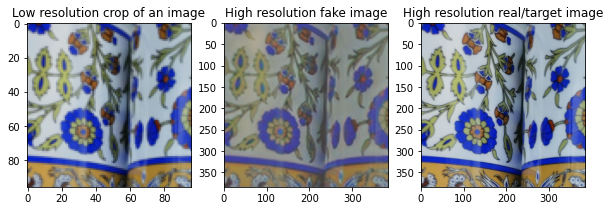

In [ ]:
G, D = train(HR_csv_location="/content/DIV2KDIV2K_train_HR.csv",
             LR_csv_location="/content/DIV2K_train_LR_bicubicX4.csv", 
             pre_train_epoch=10, 
             SRGAN_train_epoch=100, 
             batch_size=4, 
             num_workers=4)